# PyTorch Paper Replicating

This file will focus on replicating a Machine Learning research paper and creating a Vision Transformer (ViT) from scratch.

### What is paper replicating?

The goal of paper replicating is to replicate the most recent advances in Machine Learning which tend to be published in papers. Instead of using someone else's code, the focus here is to transform images, diagrams, math and text into usable code, in this case, PyTorch code.

### Where can code examples of Machine Learning research papers be found?

There is a lot of research in Machine Learning, so staying on top of the most recent advances is not easy. Said this, there are several places to find relevant papers.

Some useful resources include:
* arXiv
* AK Twitter
* Papers with Code
* lucidrains' `vit-pytorch` GitHub repository

### Which paper will be replicated?

The paper this file will focus on is An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (ViT paper)
https://arxiv.org/abs/2010.11929

The Transformer neural network architecture was originally introduced in the Machine Learning research paper Attention is all you need
https://arxiv.org/abs/1706.03762

A Transformer architecture is generally considered to be any neural network that uses the attention mechanism as its primary learning layer. This is similar to how Convolutional Neural Networks use convolutions as their primary learning layer.

The Attention Mechanism is more thoroughly explained here:
https://www.geeksforgeeks.org/ml-attention-mechanism/

As suggested by its name, the Vision Transformer (ViT) architecture was designed to adapt the original Transformer architecture to vision problems.

The original Vision Transformer has been through several iterations over the past couple of years, but we will focus on replicating the original.

For the rest of this project, we will refer to the Vision Transformer as ViT while referring to the original Machine Learning research paper as ViT paper.

## 0. Setup

In [21]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [46]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Could not find going_modular scripts. Downloading them from GitHub.")
    !git clone https://github.com/Aaron-Serpilin/Zero-To-Mastery-Pytorch
    !mv Zero-To-Mastery-Pytorch/Fundamentals/going_modular .
    !mv Zero-To-Mastery-Pytorch/Fundamental/helper_functions.py .
    !rm -rf Zero-To-Mastery-Pytorch
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [48]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [49]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [50]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into `DataLoader`'s

The ViT paper states the use of a batch size of 4096, which is considerably bigger than the batch size of 32 we have been using so far. However, we will stick with 32 because due to hardware limitations, handling batches of 4096 would be challenging.

In [51]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a5c7c52d2d0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [52]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

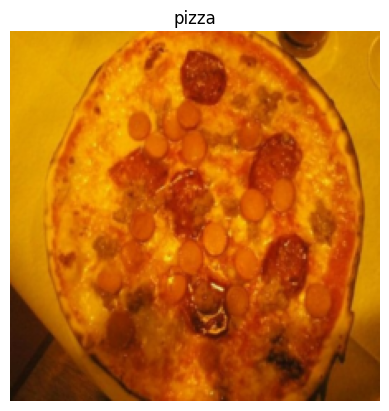

In [53]:
plt.imshow(image.permute(1, 2, 0)) # rearrange to suit matplotlib (go from [CHW] to [HWC])
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating the ViT paper: an overview